# Hierarchical Clustering

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
rfm = pd.read_csv('rfm.csv')
rfm_std = pd.read_csv('rfm_std.csv')


In [3]:
rfm_std.head()

,Unnamed: 0,Recency,Frequency,Monetary,Cluster
0,0,1.409894,-2.438202,3.707716,0
1,1,-2.146498,1.188986,1.414903,3
2,2,0.383971,-0.211465,0.720024,0
3,3,-0.574674,0.461819,0.702287,0
4,4,1.374758,-0.673554,-0.614514,2


In [4]:
# Dropping the index columns
rfm_std = rfm_std.drop(['Unnamed: 0', 'Cluster'], axis=1)
rfm_std.head()

,Recency,Frequency,Monetary
0,1.409894,-2.438202,3.707716
1,-2.146498,1.188986,1.414903
2,0.383971,-0.211465,0.720024
3,-0.574674,0.461819,0.702287
4,1.374758,-0.673554,-0.614514


Using standardized data, I will perform hierarchical clustering using Euclidean distance to compute the primary distance in the hierarchical method, which is the distance between observations. For a little refresher, hierarchical clustering is part of the agglomerative approach because it starts with each observation in its own cluster and then joins neighboring observations/clusters according to their distance until all observations are linked.

In the code below, I passed the data to the linkage() function, which produces a linkage matrix. I also used the 'Ward' method to minimize the total variance within clusters.

Furthermore, the output below is a hierarchical dendrogram, which shows how the data is clustered. The height indicates the dissimilarity between elements. The lower we move down the tree, the higher the similarity between groups/observations.

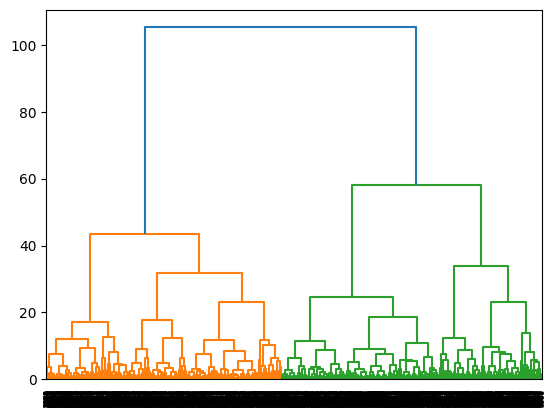

In [5]:
linkages = hierarchy.linkage(rfm_std, method = 'ward')
hierarchy.dendrogram(linkages)
plt.show()

here's a truncated tree, to close up way to see several observations, and how it clustered by the tree brances.

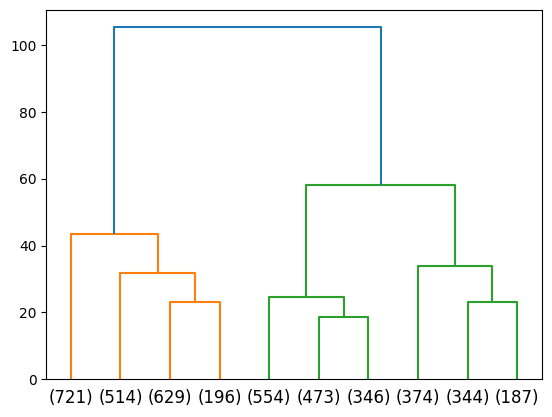

In [6]:
# show truncated tree
hierarchy.dendrogram(linkages, orientation= 'top', 
                     truncate_mode = 'lastp', p = 10)
plt.show()

To see how well our tree clustering the observations, we can use cophenetic
correlation coefficient (CPCC). This coefficient could be interepreted the same as Pearson's r. In this case, the CPCC is arounf 0.51 indicating moderate fit.

In [7]:
hierarchy.cophenet(linkages, pdist(rfm_std))[0]

0.5148899891133092

Here I am going to check the number of customers grouped in each cluster.

In [8]:
labels = hierarchy.fcluster(linkages, t=4, criterion='maxclust')
list(zip(*np.unique(labels, return_counts=True)))

[(1, 721), (2, 1339), (3, 1373), (4, 905)]

In [9]:
rfm_std

,Recency,Frequency,Monetary
0,1.409894,-2.438202,3.707716
1,-2.146498,1.188986,1.414903
2,0.383971,-0.211465,0.720024
3,-0.574674,0.461819,0.702287
4,1.374758,-0.673554,-0.614514
...,...,...,...
4333,1.298690,-1.069075,-1.102093
4334,0.999081,-1.324833,-1.735717
4335,-1.178605,-0.934910,-1.113332
4336,-1.662552,2.291307,0.822812


In [10]:
rfm_std['Cluster'] = labels
rfm_std.head()

,Recency,Frequency,Monetary,Cluster
0,1.409894,-2.438202,3.707716,2
1,-2.146498,1.188986,1.414903,4
2,0.383971,-0.211465,0.720024,3
3,-0.574674,0.461819,0.702287,3
4,1.374758,-0.673554,-0.614514,2


Let's see how well hierarchichal clustering using PCA plot

In [11]:
rfm_pca = rfm_std.drop('Cluster', axis = 1)

We can see that overall the cluster is well defined even though some points are overlapping 

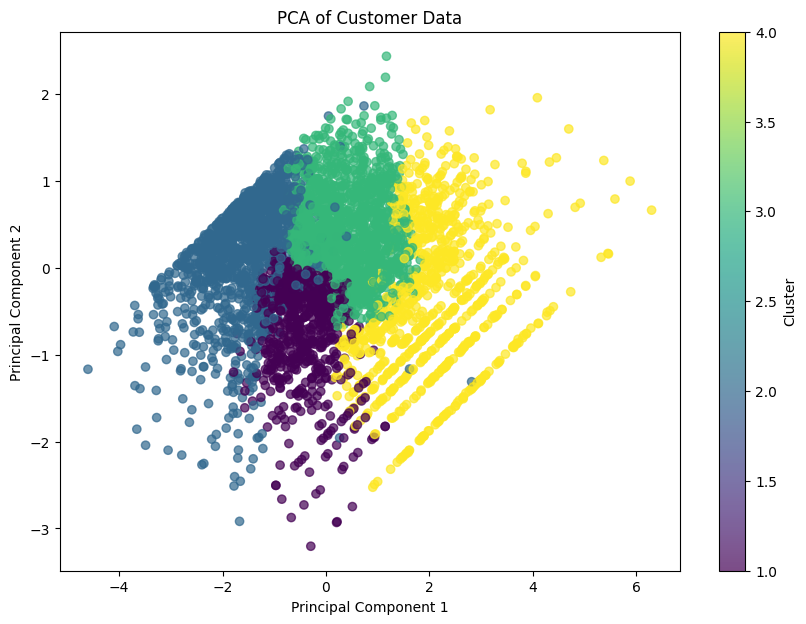

In [12]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(rfm_pca)
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

pca_df = pd.DataFrame(data=pc_df, columns=['PC1', 'PC2'])
pca_df['Cluster'] = labels

plt.figure(figsize=(10, 7))

# Scatter plot of PCA results, colored by cluster
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.7)

plt.title('PCA of Customer Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [13]:
#drop the initial cluster
rfm = rfm.drop(['Cluster', 'CustomerID'], axis = 1)
rfm.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,1,182,4310.00
2,74,31,1797.24
3,18,73,1757.55
4,309,17,334.40


In [14]:
#add the new cluster 
rfm['Cluster'] = labels


In [15]:
rfm.head()

,Recency,Frequency,Monetary,Cluster
0,325,1,77183.60,2
1,1,182,4310.00,4
2,74,31,1797.24,3
3,18,73,1757.55,3
4,309,17,334.40,2


In [16]:
pd.pivot_table(rfm, index = 'Cluster', aggfunc= 'mean')

,Frequency,Monetary,Recency
Cluster,,,
1,28.074896,386.198531,32.783634
2,16.168783,616.992240,197.653473
3,87.774217,1396.837489,72.472688
4,254.459669,6480.385934,10.259669


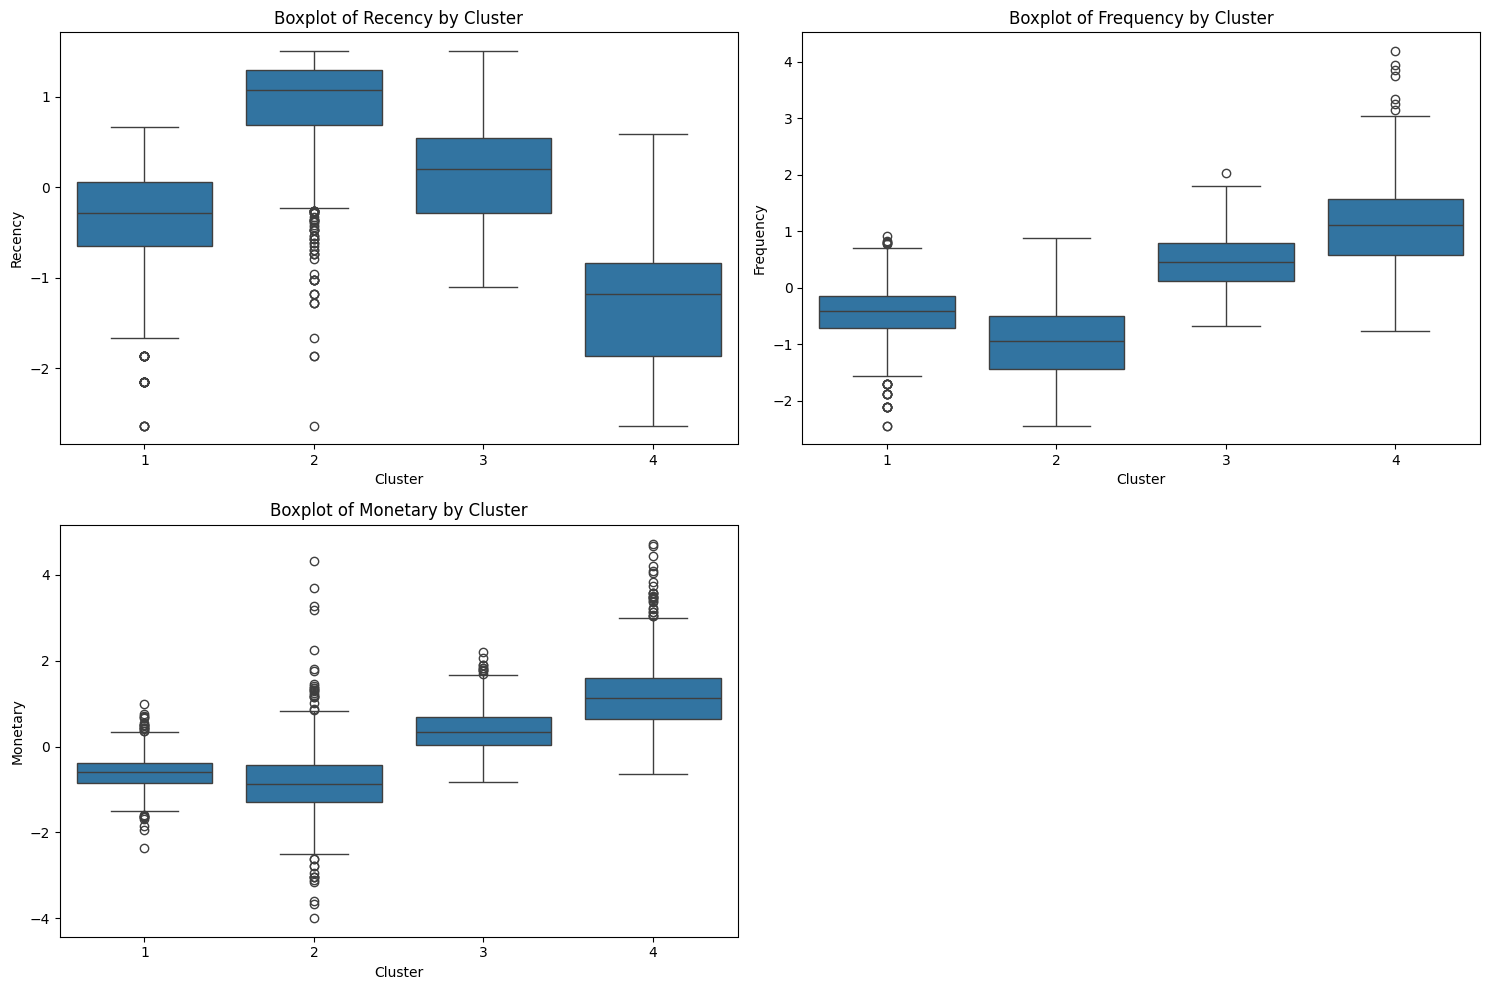

In [17]:
import seaborn as sns

plt.figure(figsize=(15,10))

features = ['Recency', 'Frequency', 'Monetary']

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x = 'Cluster', y = feature, data = rfm_std)
    plt.title(f'Boxplot of {feature} by Cluster')

plt.tight_layout()
plt.show()

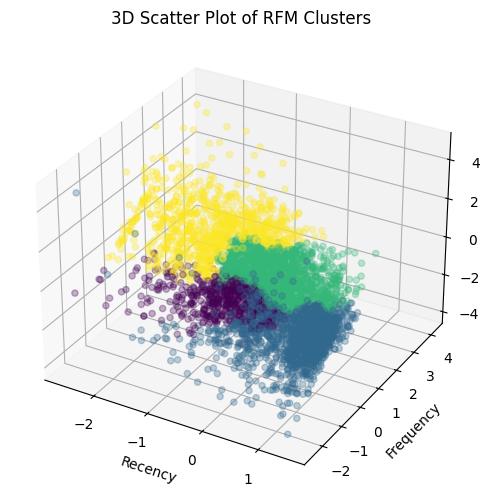

In [20]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
ax = plt.axes(projection = '3d')

#scatter plot 
ax.scatter3D(
    rfm_std['Recency'], 
    rfm_std['Frequency'], 
    rfm_std['Monetary'], 
    c = rfm_std['Cluster'], 
    cmap = 'viridis', 
    s = 20, 
    alpha = 0.3
)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.set_title('3D Scatter Plot of RFM Clusters')

ax.view_init(elev=30) 

plt.show()

In [50]:
percentiles = rfm.groupby('Cluster').quantile([0.25, 0.5, 0.75]).unstack(level=1)
print(percentiles)

        Recency               Frequency               Monetary           \
           0.25   0.50   0.75      0.25   0.50   0.75     0.25     0.50   
Cluster                                                                   
1          16.0   28.0   46.0      16.0   24.0   34.0   245.81   340.11   
2         114.5  200.0  277.0       6.0   12.0   21.5   143.73   243.36   
3          28.0   57.0   94.0      47.0   72.0  111.0   761.74  1122.36   
4           2.0    7.0   12.0      85.0  166.0  296.0  1621.73  3039.17   

                   
             0.75  
Cluster            
1         452.890  
2         417.325  
3        1741.220  
4        5398.300  


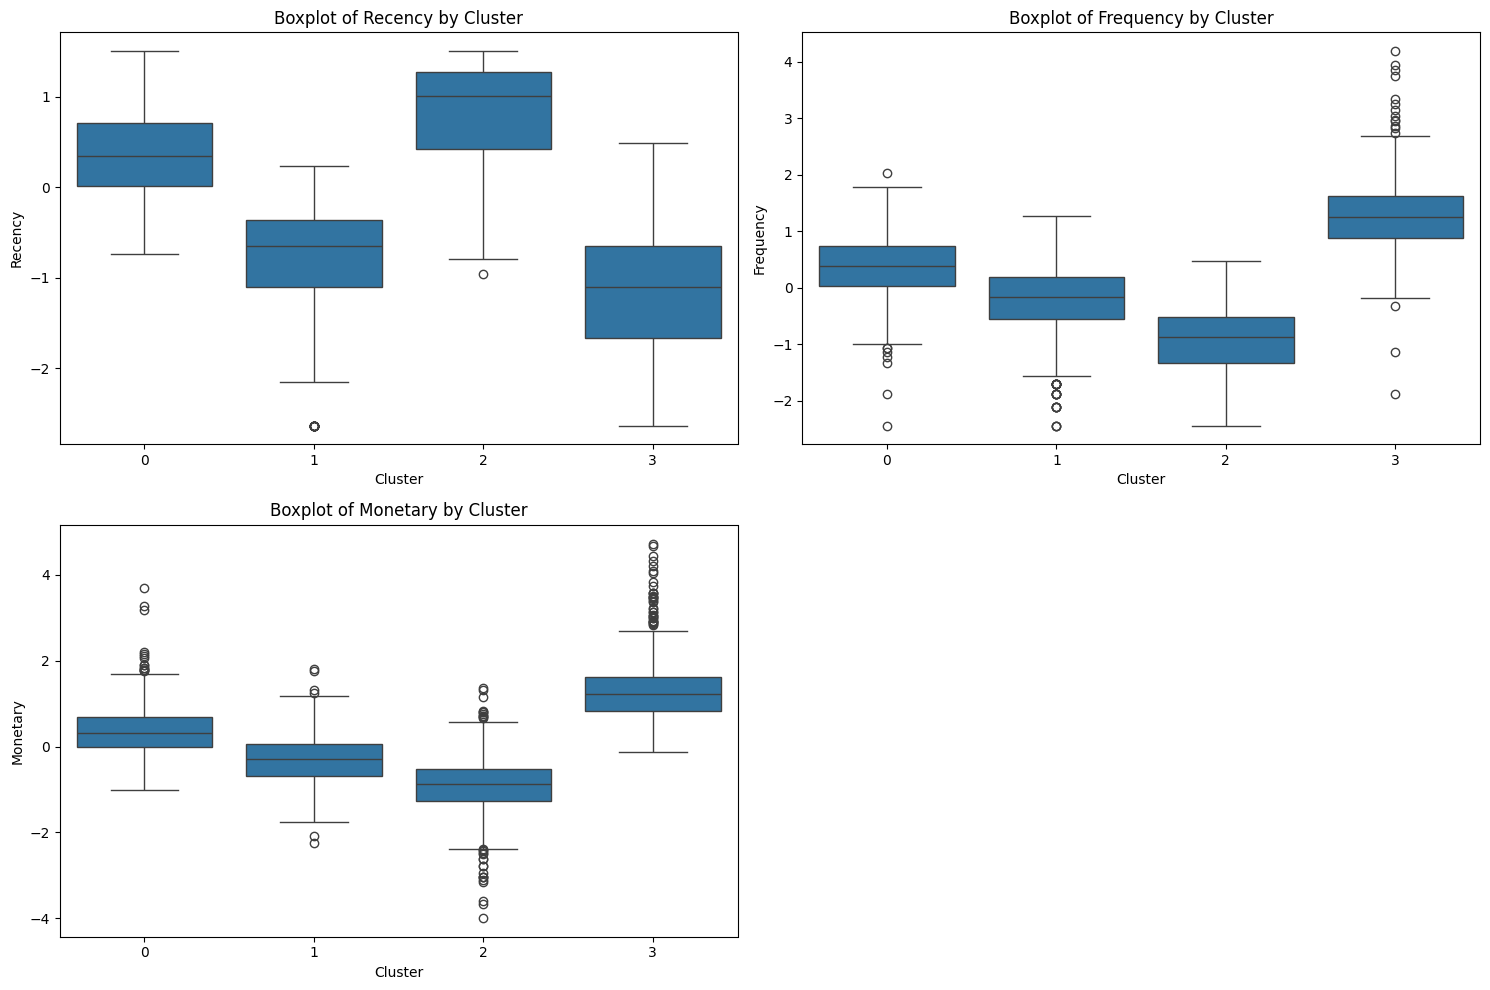

In [32]:

# visualizing how each features for each variable 
plt.figure(figsize=(15,10))

features = ['Recency', 'Frequency', 'Monetary']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x = 'Cluster', y = feature, data = rfm_std)
    plt.title(f'Boxplot of {feature} by Cluster')

plt.tight_layout()
plt.show()

In [52]:
rfm_std

,Recency,Frequency,Monetary,Cluster
0,1.409894,-2.438202,3.707716,2
1,-2.146498,1.188986,1.414903,4
2,0.383971,-0.211465,0.720024,3
3,-0.574674,0.461819,0.702287,3
4,1.374758,-0.673554,-0.614514,2
...,...,...,...,...
4333,1.298690,-1.069075,-1.102093,2
4334,0.999081,-1.324833,-1.735717,2
4335,-1.178605,-0.934910,-1.113332,1
4336,-1.662552,2.291307,0.822812,4


In [55]:
silhouette_avg = silhouette_score(rfm_std,labels)

In [56]:
silhouette_avg

0.24661274977693506

rfm.head